<a href="https://colab.research.google.com/github/utkuyucel/Deep-Learning/blob/master/Turkey_Emotion_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
!kaggle datasets download "cebeci/turkishreviews"

 95% 17.0M/17.8M [00:00<00:00, 30.1MB/s]
100% 17.8M/17.8M [00:00<00:00, 51.3MB/s]


In [ ]:
!unzip turkishreviews.zip

Archive:  turkishreviews.zip
  inflating: hb.csv                  


In [ ]:
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import numpy as np

# Cleaning the data

In [ ]:
df = pd.read_csv("hb.csv", usecols = ["Rating (Star)", "Review"])

In [ ]:
df.head()

,Rating (Star),Review
0,5,3 yıldır tık demedi. :)
1,5,3 yıldır kullanıyorum müthiş
2,4,Ürün bugün elime geçti çok fazla inceleme fırs...
3,4,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,5,Günlük kullanımınızı çok çok iyi karsılıyor kı...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272216 entries, 0 to 272215
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Rating (Star)  272216 non-null  int64 
 1   Review         272216 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.2+ MB


In [ ]:
df.isnull().sum()

Rating (Star)    0
Review           0
dtype: int64

In [ ]:
df = df.dropna(axis = 0)
df.isnull().sum()

Rating (Star)    0
Review           0
dtype: int64

In [ ]:
df

,Rating (Star),Review
0,5,3 yıldır tık demedi. :)
1,5,3 yıldır kullanıyorum müthiş
2,4,Ürün bugün elime geçti çok fazla inceleme fırs...
3,4,Almaya karar verdim. Hemencecik geldi. Keyifle...
4,5,Günlük kullanımınızı çok çok iyi karsılıyor kı...
...,...,...
272211,5,fiyatına göre güzel
272212,5,Ürün kullanışlı iş görüyor fazlasıyla eşime al...
272213,5,"Hızlı Kargo, güzel ürün"
272214,5,telefon başarılı hızlı bir cihaz sadece beyaz...


In [ ]:
# One hot encoding manually
def classify(list_input):

  if list_input == 5:
    return 1
  else:
    return 0

df["five"] = df["Rating (Star)"].apply(classify)

In [ ]:
df

,Rating (Star),Review,one,two,three,four,five
0,5,3 yıldır tık demedi. :),0,0,0,0,1
1,5,3 yıldır kullanıyorum müthiş,0,0,0,0,1
2,4,Ürün bugün elime geçti çok fazla inceleme fırs...,0,0,0,1,0
3,4,Almaya karar verdim. Hemencecik geldi. Keyifle...,0,0,0,1,0
4,5,Günlük kullanımınızı çok çok iyi karsılıyor kı...,0,0,0,0,1
...,...,...,...,...,...,...,...
272211,5,fiyatına göre güzel,0,0,0,0,1
272212,5,Ürün kullanışlı iş görüyor fazlasıyla eşime al...,0,0,0,0,1
272213,5,"Hızlı Kargo, güzel ürün",0,0,0,0,1
272214,5,telefon başarılı hızlı bir cihaz sadece beyaz...,0,0,0,0,1


In [ ]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


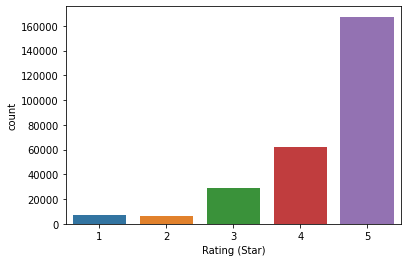

In [ ]:
sns.countplot(df["Rating (Star)"])

## Dataset is not balanced but it's ok

# Preparing for model

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Embedding, GRU, Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

import string

punc = string.punctuation

def remove_punc(text):
  x = "".join([i for i in text if i not in punc])
  return x

In [ ]:
X = df["Review"].apply(remove_punc).values.astype(str)
y = df[["one", "two", "three", "four", "five"]].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.01)

In [ ]:
max_words = 3000
max_len = 250
embedding_dim = 500

tokenizer = Tokenizer(num_words= max_words)
tokenizer.fit_on_texts(X_train)

sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(269493,)
(2723,)
(269493, 5)
(2723, 5)


In [ ]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))

model.add(LSTM(100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences = False))
model.add(Dropout(0.4))

model.add(Dense(64, activation = "relu"))
model.add(Dense(5, activation = "softmax"))

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 500)          1500000   
_________________________________________________________________
lstm (LSTM)                  (None, 250, 100)          240400    
_________________________________________________________________
dropout (Dropout)            (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 3

In [ ]:
# model = load_model("model.h5")
history = model.fit(sequences_matrix, y_train, batch_size = 2048, epochs = 10)
model.save("model.h5")

Epoch 1/10
132/132 [==============================] - 134s 765ms/step - loss: 1.1268 - acc: 0.5799
Epoch 2/10
132/132 [==============================] - 100s 760ms/step - loss: 0.8668 - acc: 0.6519
Epoch 3/10
 13/132 [=>............................] - ETA: 1:30 - loss: 0.8349 - acc: 0.6590

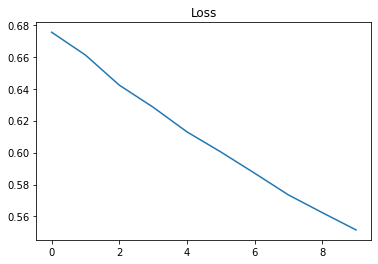

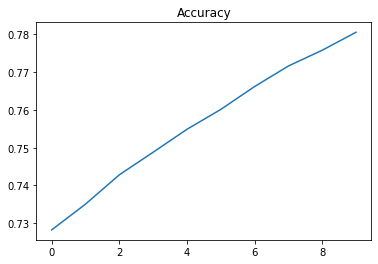

In [ ]:
import matplotlib.pyplot as plt 
plt.title("Loss")
plt.plot(history.history["loss"])
plt.show()

plt.title("Accuracy")
plt.plot(history.history["acc"])
plt.show()

In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen = max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix, y_test)

print("Accuracy on test set", accr[1])
print("Loss on test set", accr[0])

86/86 [==============================] - 1s 7ms/step - loss: 0.9974 - acc: 0.6048
Accuracy on test set 0.6048476099967957
Loss on test set 0.9974156022071838


In [ ]:
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(269493,)
(2723,)
(269493, 5)
(2723, 5)


In [ ]:
def eval(test):

  test = remove_punc(test)
  test2 = tokenizer.texts_to_sequences([test])
  test2_sequences_matrix = sequence.pad_sequences(test2, maxlen = max_len)
  
  predictions = model.predict(test2_sequences_matrix)

  labels = ["one", "two", "three", "four", "five"]

  predictions = pd.DataFrame(predictions, columns = labels)
  
  return predictions

In [ ]:
eval("Hafif tıkırtı geliyor ancak gayet memnunum")

,one,two,three,four,five
0,0.000382,0.006699,0.121649,0.41822,0.453049


In [ ]:
eval("çöp")

,one,two,three,four,five
0,0.256614,0.406026,0.074479,0.122702,0.140179
